In [1]:
import pandas as pd
from nltk.metrics.distance import edit_distance
import random
import re
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
import torch
from rlhfutils.rewards import allmathpreds, get_synth_rewards
from tqdm import tqdm
import matplotlib.pyplot as plt
from statistics import mean

/u/prasanns/miniconda3/envs/rlhfenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
tmp = Dataset.load_from_disk('../../data/einstein/einsteinsft/')

In [4]:
# Quick look at PRM800K
# df = pd.read_json("data/phase2_train.jsonl", lines=True, orient='records')

# df.loc[2]['question']

In [3]:
def generate_expression_with_depth(depth, current_depth=""):
    # operation will be fixed for each layer
    operation = random.choice(['+', '-', '*'])

    def randexp(giveexp, ndepth):
        if giveexp: 
            giveexp = random.choice([True, False])
            if 'r' not in ndepth:
                giveexp=True
        # giveexp = givenum or ('r' not in nstr)
        return generate_expression_with_depth(depth, ndepth) if giveexp else random.randint(1,9)

    left_expr = randexp(len(current_depth)<depth, current_depth+'l')
    right_expr = randexp(len(current_depth)<depth, current_depth+'r')
    return f"({left_expr} {operation} {right_expr})" 

def solve_expression(expression):
    steps = [expression]
    
    # Use a loop to solve the expression step by step
    while '(' in expression or '+' in expression or '-' in expression or '*' in expression:
        # Solve the innermost parentheses first
        inner_parentheses = re.findall(r'\([^\(\)]*\)', expression)
        if inner_parentheses:
            for ip in inner_parentheses:
                # Evaluate the expression inside the parentheses
                result = eval(ip)
                expression = expression.replace(ip, str(result), 1)
                steps.append(expression)
        else:
            # If no parentheses are left, solve the remaining expression
            result = eval(expression)
            expression = str(result)
            steps.append(expression)
            break
            
    return steps

def calculate_rewards(predictions, golds=None, log=False):
    if type(predictions)==str:
        predictions = predictions.split(" = ")
    if golds is None: 
        golds = solve_expression(predictions[0])
    if log:
        print(predictions)
        print(golds)
    if type(golds)==str:
        golds = golds.split(" = ")
    rewards = []
    for pred, gold in zip(predictions, golds):
        max_length = max(len(pred), len(gold))
        # make reward without accounting for spaces
        norm_edit_dist = edit_distance(pred.replace(" ", ""), gold.replace(" ", "")) / max_length if max_length > 0 else 0
        reward = 1 - norm_edit_dist
        rewards.append(reward)
    
    return rewards
    
# Example: Generate an expression with a depth of 3
depth = 2
expression_with_depth = generate_expression_with_depth(depth)
solution_steps_with_depth = solve_expression(expression_with_depth)

expression_with_depth, solution_steps_with_depth

('(((3 + 3) + 9) + 9)',
 ['(((3 + 3) + 9) + 9)', '((6 + 9) + 9)', '(15 + 9)', '24'])

In [4]:
def makesftdset(depth=2, dsetsize=50000): 
    exprs = [generate_expression_with_depth(depth) for i in range(dsetsize)]
    steps = [' = '.join(solve_expression(e)) for e in exprs]
    return Dataset.from_dict({'question': exprs, 'outputs':steps})

In [7]:
# CODE TO MAKE INITIAL SFT MODELS
# mathdata = makesftdset()
# mathdata.save_to_disk("../../data/math/mathsftinitial")

In [12]:
allgens = genall(mod, mathprefdata['question'], 512)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [09:26<00:00,  2.89s/it]


In [17]:
prefdset = mathprefs(allgens)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [01:31<00:00, 543.88it/s]


In [37]:
prefdsetc = prefdsetc.map(correct_prefs, num_proc=10)

In [45]:
mean(prefdset['score_k'] + prefdset['score_j'])

3.1381721644525453

In [39]:
prefdsetc.save_to_disk("../../data/math/mathprefdata")

(array([25733., 13054.,  5631.,  2225.,   930.,   857.,   851.,   451.,
          137.,   131.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

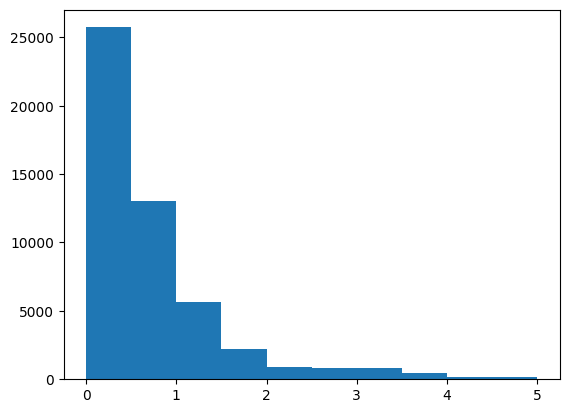

In [34]:
plt.hist(prefdsetc['magnitude'])

In [5]:
# def correct_prefs(ex):
#     tmpjr = ex['response_j']
#     tmpsr = ex['score_j']
#     ex['magnitude'] = -1 * ex['magnitude']
#     ex['response_j'] = ex['response_k']
#     ex['score_j'] = ex['score_k']
#     ex['response_k'] = tmpjr
#     ex['score_k'] = tmpsr
#     return ex

def correct_prefs(ex):
    
    ex['response_j'] = ex['response_j'].strip()
    ex['response_k'] = ex['response_k'].strip()
    
    return ex

In [7]:
# CODE TO MAKE PPO DATASET
def procinps(ex):
    ex['question'] = ex['question'] + " = "
    return ex

def genall(md, text_list, bs=16):
    newgens = []
    ntl = []
    for t in text_list:
        ntl.extend([t]*2)
    for i in tqdm(range(0, len(ntl), bs)):
        inps = tok(ntl[i:i+bs], return_tensors="pt", padding=True, truncation=True).to(mod.device)
        out = mod.generate(**inps, do_sample=True, top_p=1, max_new_tokens=100, min_new_tokens=-1)
        newgens.extend(tok.batch_decode(out, skip_special_tokens=True))
    return newgens

def mathprefs(genlist): 
    alldata = []
    for i in tqdm(range(0, len(genlist), 2)):
        tmp = {
            'question':genlist[i].split(" = ")[0] + " = ", 
        }
        resps = [g[len(tmp['question']):] for g in genlist[i:i+2]]
        scos = allmathpreds(resps)
        jind = 0 if scos[0]>scos[1] else 0
        tmp['response_j'] = resps[jind]
        tmp['response_k'] = resps[1-jind]
        tmp['score_j'] = scos[jind]
        tmp['score_k'] = scos[1-jind]
        tmp['magnitude'] = tmp['score_j'] - tmp['score_k']
        alldata.append(tmp)
    return Dataset.from_list(alldata)
        
    
ppodata = makesftdset(1, 200000)
ppodata = ppodata.map(procinps, num_proc=10)
# ppodata.save_to_disk("../../data/math/mathppoinps200k")

In [12]:
ppodata[3]

{'question': '((9 * 9) * (3 * 2)) = ',
 'outputs': '((9 * 9) * (3 * 2)) = (81 * (3 * 2)) = (81 * 6) = 486'}

In [15]:
easy2 = ppodata.filter(lambda ex: ex['question'].count("(")<=2)


In [21]:
easy2.save_to_disk("../outputs/data/math/easy2_100k")

(array([100015.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  99985.]),
 array([2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ]),
 <BarContainer object of 10 artists>)

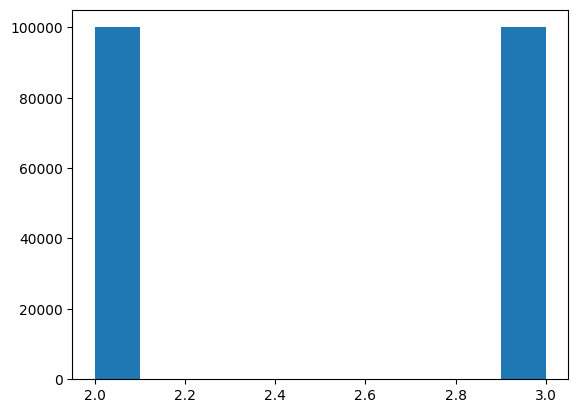

In [14]:
plt.hist([q.count("(") for q in ppodata['question']])

In [10]:
mathprefdata = makesftdset()
mathprefdata = mathprefdata.map(procinps, num_proc=10)

In [11]:
# check whether this thing actually works or not
tok = AutoTokenizer.from_pretrained("facebook/opt-125m", padding_side='left')
mod = AutoModelForCausalLM.from_pretrained("facebook/opt-125m", device_map=3, torch_dtype=torch.bfloat16, attn_implementation="flash_attention_2")
mod = PeftModel.from_pretrained(mod, "../../checkpoints/math/mathsftinitial_sft/checkpoint-1300/")

/u/prasanns/miniconda3/envs/rlhfenv/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [12]:
testset = makesftdset(2, 1000)

In [63]:
def a(input, val):
    return val

In [64]:
tup = tuple([0])
tup = tup + tuple([9])
a(*tup)

9

In [17]:
ind = 1
inpstr = testset['question'][ind]+" = "
inps = tok(inpstr, return_tensors="pt").to(mod.device)
out = mod.generate(**inps, do_sample=True, top_p=1, max_new_tokens=100, min_new_tokens=-1, num_return_sequences=2)
# print(tok.batch_decode(out, skip_special_tokens=True)[0])
out = tok.batch_decode(out, skip_special_tokens=True)[0]
# print(testset['outputs'][ind])
# print(out)
# print(calculate_rewards(out, None, True))
# einstein_reward(out, stmp[0]['sol_rows'], True)

In [19]:
len(out)

254

In [38]:
# Example usage
predictions = ["((3 + 4) - (1 * 8)) * 1", "(7 - (1 * 8)) * 1", "(7 - 8) * 1", "-1 * 1"]
golds = ["((3 + 4) - (1 * 8)) * 1", "(7 - 8) * 1", "-1 * 1", "-1"]
rewards = calculate_rewards(predictions, golds)

rewards

[1.0, 0.7647058823529411, 0.6363636363636364, 0.6666666666666667]

In [76]:
def a(inp):
    print(inp)

In [70]:
from rlhfutils.rewards import allmathpreds

In [83]:
ts = ["((4)+1) = (4+1) = 4"]
inps = tuple([ts])

In [84]:
allmathpreds(*inps)

[2.5]

In [3]:
bowdata = Dataset.load_from_disk("../../data/bagofwords/nozero100k/")

In [11]:
get_synth_rewards([bowdata[0]['response_k']], 'bagofwords')

[0.0]